# Variational Gaussian Processes

The Variational Free Energy (VFE) method {cite}`titsias2009variational` applied to GPs, is an approach for approximating the posterior $p(f | \mathbf{y}, \mathbf{X})$ of a Gaussian Process. Instead of computing the exact GP posterior, VFE approximates it by another Gaussian distribution, which is cheaper to manipulate when making predictions or evaluating the marginal likelihood $p(\mathbf{y} | \mathbf{X})$. Similarly to other GP approximations, VFE achieves lower a computational cost by making sparsity assumptions. However, whereas other sparse methods like FITC and DTC make sparsity assumptions on the *likelihood*, VFE makes these assumptions on the *approximate posterior* and this has several important effects. $ \def\Kxx{\mathbf{K}_{\mathbf{X}\mathbf{X}}}
 \def\Kxb{\mathbf{K}_{\mathbf{X}\mathbf{\bar{X}}}}
 \def\Kbx{\mathbf{K}_{\mathbf{\bar{X}}\mathbf{X}}}
 \def\Kbb{\mathbf{K}_{\mathbf{\bar{X}}\mathbf{\bar{X}}}}
 \def\Ksb{\mathbf{K}_{\mathbf{X^*}\mathbf{\bar{X}}}}
 \def\Kbs{\mathbf{K}_{\mathbf{\bar{X}}\mathbf{X^*}}}
 \def\Ksx{\mathbf{K}_{\mathbf{X^*}\mathbf{\bar{X}}}}
 \def\Kxs{\mathbf{K}_{\mathbf{\bar{X}}\mathbf{X^*}}}
 \def\Kss{\mathbf{K}_{\mathbf{X^*}\mathbf{X^*}}}
 \def\fx{\mathbf{f}_{\mathbf{X}}}
 \def\fnb{f_{\neq \mathbf{\bar{X}}}}
 \def\fb{\mathbf{f}_{\mathbf{\bar{X}}}}
 \def\fstar{\mathbf{f}_{\mathbf{X^*}}}
 \def\X{\mathbf{x}}
 \def\xstar{\mathbf{x^*}}
 \def\X{\mathbf{X}}
 \def\Xb{\mathbf{\bar{X}}}
 \def\lrb[#1]{\left(#1\right)}
 \def\lrs[#1]{\left[#1\right]}
 \def\mb[#1]{\mathbf{#1}}
 \DeclareMathOperator*{\argmax}{arg\,max}
 \DeclareMathOperator*{\argmin}{arg\,min}
 \newcommand{\bs}[1]{\boldsymbol{#1}}
 \newcommand{\bm}[1]{\mathbf{#1}} $

In [11]:
import numpy as np
import matplotlib.pyplot as plt

from IPython.display import HTML, set_matplotlib_formats

set_matplotlib_formats('pdf', 'svg')
css_style = open('../../../_static/custom_style.css', 'r').read()
HTML(f'<style>{css_style}</style>')

## The Variational Free Energy

Often, the log marginal likelihood of the data can be costly or intractable to compute. To circumvent this difficulty, one solution is to optimise an alternative objective instead of the log-marginal. This objective should be chosen such that (1) it is cheap to evaluate; (2) optimising it cannot lead to worse overfitting than the original model. The Variational Free Energy (VFE), also known as the ELBO, can be used to meet both these criteria. The precise same bound is used for a variety of other models involving latent variables - including Gassian Mixture Models, Variational Autoencoders or Bayesian Networks to mention a few.

The VFE meets the two criteria above because (1) it can be cheap to evaluate if we make sensible approximation choices; (2) it lower bounds the marginal likelihood, so we can optimise it with respect to the hyperparameters without fear of overfitting any worse than the exact model would. The latter point is especially important because it decouples modelling assumptions (the awesome model we'd like to have) from our approximations (which we make out of computational necessity). A user can therefore state their assumptions clearly upfornt and buy themselves as good an approximation to the exact model as their comptational budget can afford them. We'll expand on this further, later.

Here is a short derivation for the VFE, which can be used as a starting point for *any* latent variable model. Suppose we want to evalate the marginal likelihood of some data $\mathbf{y}$ given some other data $\mathbf{x}$ under a model with latent variables $\mathbf{s}$ and parameters $\bs{\theta}$

$$\begin{align}
p(\mathbf{y} | \mathbf{x}, \bs{\theta}) = \int p(\mathbf{y}, \mathbf{s} | \mathbf{x}, \bs{\theta}) d \mathbf{s}
\end{align}$$

For Gaussian mixture models, $\mathbf{s}$ are cluster memberships of the datapoints, often written $\mathbf{c}$. For VAEs, $\mathbf{s}$ is the latent representation, often written $\mathbf{z}$. For GPs it will denote a set of latent function values $\mathbf{f}$. Now, defining a new probability distribution over $\mathbf{s}$, written $q(\mathbf{s})$. This is widely referred to as the *variational posterior*. If we subtract the KL divergence between $q(\mathbf{s})$ and the true posterior $p(\mathbf{s} | \mathbf{y}, \mathbf{x})$ from the marginal likelihood, we get the inequality

$$\begin{align}
\log p(\mathbf{y} | \mathbf{x}) \geq \mathcal{F}(q, \bs{\theta}) &= \int q(\mathbf{s}) \log p(\mathbf{y} | \mathbf{x}, \bs{\theta}) d \mathbf{s} + \int q(\mathbf{s}) \log \frac{p(\mathbf{s} | \mathbf{y}, \mathbf{x}, \bs{\theta})}{q(\mathbf{s})} d\bm{s} \\
&= \int q(\mathbf{s}) \log \frac{p(\mathbf{y}, \mathbf{s} | \mathbf{x}, \bs{\theta})}{q(\mathbf{s})} d\bm{s},
\end{align}$$

where we have used the fact that the KL is non-negative. This shows that the VFE, $\mathcal{F}$, is a lower bound to the exact marginal likelihood. We made no assumptions about the distribution $q$ and the inequality always holds, irrespective of our choice of $q$. The inequality becomes an equality when $q$ is equal to the true posterior, where the KL divergence becomes zero, attaining its minimum value. Although we could pick $q$ to be any distribution we like, we should seek a $q$ which makes $\mathcal{F}$ as large as possible while still remaining computationally tractable. It turns out that the VFE approximation for GPs achieves an excellent tradeoff between approximating the true posterior and keeping the computational cost low.

## Sparse VFE approximation

Using the idea of introducing inducing points, much like those of the  DTC{cite}`seeger2003fast` or FITC{cite}`snelson2005sparse` approximations, we will see how the VFE approximation will result in an approximate form which is significantly cheaper to work with than the exact GP. Unlike the DTC or FITC however, VFE approximates the posterior over the latent function $f$ rather than the model. Whereas models like DTC or FITC can overfit when optimising their inducing points and model parameters $\theta$, the VFE approximation does not run this risk at all because it uses the Free Energy to optimise inducing points and parameters. Since the Free Energy is a lower bound to the exact log-marginal likelihood, VFE is guaranteed not to overfit any more than the exact GP would.

### Model and approximate $q$

Let's start by stating our assumptions and inference approximations. First, define the input variables $\mathbf{X} = (\mathbf{x}_1, \mathbf{x}_2, ..., \mathbf{x}_N)^\top$ and the values of the function $f$ at these input locations as $\mathbf{f}_\mathbf{X} = (f_{\mathbf{x}_1}, f_{\mathbf{x}_2}, ..., f_{\mathbf{x}_N})^\top$, placing a zero-mean GP prior over them, so that

$$\begin{align}
p(\mathbf{f}_\mathbf{X} |\mathbf{X}, \bs{\theta}) \sim \mathcal{N}\lrb[\mathbf{0}, \bm{K}_{\bm{X}\bm{X}}].
\end{align}$$

Now define the observed variables $\mathbf{y} = (y_1, y_2, ..., y_N)^\top$, obtained by adding noise to $\mathbf{f}$

$$\begin{align}
p(\mathbf{y}| \mathbf{f}_\mathbf{X}) \sim \mathcal{N}\lrb[\mathbf{f}_\mathbf{X}, \sigma^2 \bm{I}],
\end{align}$$

so that the marginal likelihood of $\mathbf{y}$ given $\bm{X}$ is

$$\begin{align}
p(\mathbf{y}| \bs{\theta}) \sim \mathcal{N}\lrb[\mathbf{0}, \bm{K}_{\bm{X}\bm{X}} + \sigma^2 \bm{I}].
\end{align}$$

This is the exact GP model, describing precisely how the inputs $\mathbf{X}$ and outputs $\mathbf{y}$ are related. Exact inference and learning in this model is impossible because it involves the inversion of the full rank matrix $\bm{K}_{\bm{X}\bm{X}} + \sigma^2 \bm{I}$. To circumvent this, the VFE method places an approximate posterior based on inducing points. Let $\mathbf{\bar{X}} = (\mathbf{\bar{x}}_1, \mathbf{\bar{x}}_2, ..., \mathbf{\bar{x}}_M)^\top$ be a set of inducing inputs, different from $\mathbf{X}$, and let $\fb = (f_{\mathbf{\bar{x}}_1}, f_{\mathbf{\bar{x}}_2}, ..., f_{\mathbf{\bar{x}}_N})^\top$ be the corresponding function values at these points, called the inducing values. The VFE approximation chooses the approximate posterior to be

$$\begin{align}
q(f) = p\left(\fnb | \fb\right)  q\left(\fb\right),
\end{align}$$

where $f$ is the full latent function and $q\left(\fb\right)$ is a free-form distribution to be optimised. Note that we have slightly abused notation, using $q$ to denote both the variational distribution over the full latent function $f$ as well as the variational distribution over the inducing point values $\fb$. This $q$ separates $\fnb$ from the data $\mathbf{y}$ and instead uses the inducing values $\fb$ to summarise the dataset and bring the approximate posterior $q(f)$ close to the true posterior.

### Maximising the VFE

We now look to maximise $\mathcal{F}$ with respect to $q$

$$\begin{align}
q^* = \argmax_{q} \mathcal{F}(q, \bs{\theta}).
\end{align}$$

This maximisation can be performed in closed form. Perhaps unsuprisingly, the optimal $q^*$ is also a Gaussian distribution.

<div class="lemma">
    
**Lemma (Optimal $q^*$)** The variational posterior $q^*$ which maximises the variational free energy is
    

$$\begin{align}
q^*\lrb[\fb] = \mathcal{N}\lrb[\fb;~\sigma^{-2} \Kbb \bs{\Sigma}^{-1} \Kbx \mathbf{y},~\Kbb\bs{\Sigma}^{-1}\Kbb]
\end{align}$$

where $\bs{\Sigma}^{-1} = \lrb[\Kbb + \sigma^{-2} \Kbx \Kxb]$. The corresponding free energy is
    
$$\begin{align}
\mathcal{F}(q^*, \bs{\theta}) = \mathcal{N}\lrb[\bm{y}; \bm{0}, \sigma^2 \bm{I} + \Kxb \Kbb^{-1} \Kbx] - \frac{1}{2\sigma^2} \text{Tr}\lrb[\Kxx - \Kxb\Kbb^{-1}\Kbx].
\end{align}$$
    
</div>
<br>

<details class="proof">
<summary>Derivation: Optimal \(q^*\)</summary>

Substituting the approximate posterior into $\mathcal{F}$, we obtain 

$$\begin{align} \require{cancel}
\mathcal{F}(q, \bs{\theta}) &= \int p\lrb[f_{\neq \Xb} | \fb] q\lrb[\fb | \mathbf{y}] \log \frac{p(\mathbf{y}, f | \bs{\theta})}{p\lrb[f_{\neq \Xb} | \fb] q\lrb[\mathbf{f}_{\mathbf{\bar{X}}} | \mathbf{y}]} df \\
&= \int p\lrb[f_{\neq \Xb} | \fb] q\lrb[\fb | \mathbf{y}] \log \frac{p(\mathbf{y} | \fx, \bs{\theta})  \cancel{p\lrb[f_{\neq \Xb} | \fb]}  p\lrb[\fb]}{\cancel{p\lrb[f_{\neq \Xb} | \fb]} q\left(\fb | \mathbf{y} \right)} df \\
&= \int p\lrb[\fx | \fb] q\lrb[\fb | \mathbf{y}] \log \frac{p(\mathbf{y} | \fx, \bs{\theta}) p(\fb)}{ q\lrb[\fb | \mathbf{y}]} d\fx d\fb.
\end{align}$$
    
Now we seek to minimise $\mathcal{F}(q, \bs{\theta})$ with respect to $q$. This requires a variational approach since $q$ is a function, and also requires a Lagrange multiplier because $q$ must be constrained to integrate to $1$ since it is a distribution. Optimising $\mathcal{F}(q, \bs{\theta})$ subject to this constraint is equivalent to optimising the Lagrangian $\mathcal{L}$ without constraints
    
$$\begin{align}
\mathcal{L} &= \mathcal{F}(q, \bs{\theta}) - \lambda \left( \int q\lrb[\fb | \mathbf{y}] d\fb - 1 \right) \\
&= \int p\lrb[\fx | \fb] q\lrb[\fb | \mathbf{y}] \log \left[p(\mathbf{y} | \fx, \bs{\theta}) p(\fb)\right] d\fx d\fb - \int p\lrb[\fx | \fb] q\lrb[\fb | \mathbf{y}] \log q\lrb[\fb | \mathbf{y}] d\fx d\fb - \lambda \left( \int q\lrb[\fb | \mathbf{y}] d\fb - 1 \right).
\end{align}$$
    
Setting the (variational) derivative of $\mathcal{F}$ w.r.t. $q$ to 0, we obtain:

$$\begin{align}
\frac{\delta \mathcal{L}}{\delta q} &= \int p\lrb[\fx | \fb] \log p(\mathbf{y} | \fx, \bs{\theta}) d\fx + \log p\lrb[\fb] - \lrb[ \log q^*\lrb[\fb | \mathbf{y}] + 1] - \lambda = 0
\end{align}$$
    
    
$$\begin{align}
q^*\lrb[\fb | \mathbf{y}] = \frac{1}{Z} p\lrb[\fb]\exp \int p\lrb[\fx | \fb] \log p(\mathbf{y} | \fx, \bs{\theta}) d\fx
\end{align}$$
    
Substituting $p\lrb[\mathbf{y} | \fx] = \mathcal{N}\lrb[\mathbf{y}; \fx, \sigma^2 \mathbf{I}]$ we obtain

$$\begin{align}
q^*\lrb[\fb | \mathbf{y}] = \frac{1}{Z} p\lrb[\fb] \exp \lrb[-\frac{N}{2}\log\lrb[2\pi\sigma^2] - \frac{1}{2\sigma^2} \underbrace{\int \lrb[\mathbf{y}^\top \mathbf{y} - 2 \mathbf{y}^\top \fx + \fx^\top \fx ] p\lrb[\fx | \fb] d\fx}_{= M}].
\end{align}$$

Using the fact that $\fx^\top \fx = \text{Tr}\lrb[\fx \fx^\top]$ and substituting for $p\left(\fx | \fb \right)$ and $p\lrb[\fb]$ into $\mathcal{F}$, we evaluate the integral as:

$$\begin{align}
M = \mathbf{y}^\top \mathbf{y} - 2 \mathbf{y}^\top \Kxb \Kbb^{-1} \fb  + \fb^\top \Kbb^{-1} \Kbx \Kxb \Kbb^{-1} \fb + \text{Tr}\lrb[\Kxx - \Kxb \Kbb^{-1} \Kbx].
\end{align}$$

We can now read off the $q^*$ distribution easily as follows. Since $M$ is a quadratic form in $\fb$, the whole exponential term above is an unnormalised Gaussian. The $p\lrb[\fb]$ term is also a Gaussian, so its product with the exponential term will also be an unnormalised Gaussian in $\fb$, thus arriving at the result that the optimal $q^*$ is also a Gaussian. We only have to determine the mean and covariance of the overall $q^*$ and need not bother with constants at this stage. Using the standard results for the mean and covariance of a product of Gaussians we obtain

$$\begin{align}
q^*\lrb[\fb | \mathbf{y}] = \mathcal{N}\lrb[\fb;~\sigma^{-2} \Kbb \bs{\Sigma}^{-1} \Kbx \mathbf{y},~\Kbb\bs{\Sigma}^{-1}\Kbb]
\end{align}$$

where $\bs{\Sigma}^{-1}$ is given by
    
$$\begin{align}
\bs{\Sigma}^{-1} &= \lrb[\Kbb + \sigma^{-2} \Kbx \Kxb]^{-1}.
\end{align}$$
    
Substituting this back into the free energy we obtain
    
$$\begin{align}
\mathcal{F}(q^*, \bs{\theta}) = \mathcal{N}\lrb[\bm{y}; \bm{0}, \sigma^2 \bm{I} + \Kxb \Kbb^{-1} \Kbx] - \frac{1}{2\sigma^2} \text{Tr}\lrb[\Kxx - \Kxb\Kbb^{-1}\Kbx].
\end{align}$$

</details>
<br>

Looking at this expression for $\mathcal{F}$, we observe that the first term is a Gaussian involving a covariance with special structure. The $\sigma^2 \bm{I}$ term is diagonal, while the $\Kxb \Kbb^{-1} \Kbx$ has rank $\min(M, N)$. Such matrices can be inverted in $\mathcal{O}\lrb[\min(M, N)^3]$ time, using the [Woodbury Identity](https://en.wikipedia.org/wiki/Woodbury_matrix_identity). The second term involves the trace of a matrix which, when $M < N$, requires $\mathcal{O}\lrb[NM^2]$ to compute. Therefore, the overal complexity of computing $\mathcal{F}$ is $\mathcal{O}\lrb[NM^2]$, which is a significant gain over $\mathcal{O}\lrb[N^3]$ if $M << N$.

### Posterior predictive

We are also interested in making predictions at new test points. In order to achieve this in a computationally efficient way, we can use $q^*$ and evaluate

$$\begin{align}
p\lrb[\bm{y}^* | \bm{X}^*, \Xb] \approx \int p\lrb[\bm{y}^* | \fstar] p\lrb[\fstar | \fb] q\lrb[\fb] d\fb d\fstar.
\end{align}$$

Again, we can do this calculation in closed form to obtain an (approximate) predictive posterior.

<div class="lemma">
    
**Lemma (Approximate predictive posterior)** Under the optimal approximate posterior $q^*$, the predictive posterior of the VFE approximation is
    
$$\begin{align}
p\lrb[\bm{y}^* | \X^*, \Xb] = \mathcal{N}\lrb[\bm{y}^*; \sigma^{-2} \Ksb \bs{\Sigma}^{-1} \Kbx \mathbf{y}, \Kss - \Ksb \Kbb^{-1}\Kbs + \Ksb \bs{\Sigma}^{-1} \Kbs].
\end{align}$$
    
</div>
<br>


<details class="proof">
<summary>Derivation: Approximate predictive posterior</summary>

Starting from the expression for the approximate predictive posterior
    
$$\begin{align}
p\lrb[\bm{y}^* | \bm{X}^*, \Xb] \approx \int p\lrb[\bm{y}^* | \fstar] p\lrb[\fstar | \fb] q\lrb[\fb] d\fb d\fstar,
\end{align}$$

and remembering that the exact $p\lrb[\fstar | \fb]$ is
    
$$\begin{align}
p\lrb[\fstar | \fb] = \mathcal{N}\lrb[\fstar;~\Ksb\Kbb^{-1}\fb,~\Kss - \Ksb\Kbb^{-1}\Kbs],
\end{align}$$
    
we obtain, using standard results for the product of Gaussians and marginals of Gaussians
    
    
$$\begin{align}
p\lrb[\bm{y}^* | \X^*, \Xb] = \mathcal{N}\lrb[\bm{y}^*; \sigma^{-2} \Ksb \bs{\Sigma}^{-1} \Kbx \mathbf{y}, \Kss - \Ksb \Kbb^{-1}\Kbs + \Ksb \bs{\Sigma}^{-1} \Kbs].
\end{align}$$
    
</details>
<br>

To evaluate this predictive posterior, we need to invert the $M \times M$ matrix $\Kbb$, costing us $\mathcal{O}\lrb[M^3]$, and also to compute certain matrix products, the worst of which will cost us $\mathcal{O}\lrb[NM^2]$, making the overall cost scale as $\mathcal{O}\lrb[NM^2]$ when $M < N$, just as with the free energy.

### Cost and quality

Let's take a moment to review the VFE approximation. How did we achieve the improvement from $\mathcal{O}\lrb[N^3]$ to $\mathcal{O}\lrb[NM^2]$? In the original GP posterior predictive, we considered statistical relationships between all datapoints $\X, \bm{y}$ and the prediction points $\X^*, \bm{y}^*$

By approximating $p\lrb[f | \bm{y}, \X]$ with the distribution $p\lrb[f_{\neq \Xb} | \fb] q\lrb[\fb]$, we instead account for statistical relationships only between $\fb$ and $f$, thereby reducing the cost of evaluating the posterior predictive. The information of how $\mathbf{y}$ affects $\mathbf{y}^*$ is entirely contained in the distribution $q\lrb[\fb]$, the form of which is picked to approximate the the true posterior as accurately as possible. Although this summarised representation reduces the cost of making predictions, it also limits the set of posterior distributions which can be accurately represented by our model. A way in which this approximation might fail is if there are not enough inducing points to sufficiently constrain the approximate posterior - consider the extreme case of using a single (or zero) inducing points to model many data points. This could be either due to picking too small an $M$, or placing the inducing points' inputs $\Xb$ at poor locations, leaving large areas of the input space uncovered.

As the dataset size $N$ increases, a greater number of inducing points may be needed. In particular, if we wish to approximate the exact posterior $p\lrb[\fx | \fb]$ sufficiently accurately throughout a larger input region, we may need more inducing points and thus a larger $M$. The scaling of $M$ will therefore depend on (1) the distribution of input data $\bm{X}$, (2) the type of kernel used and (3) the specified quality of approxmation, for example in KL distance.

Clearly, the positions $\Xb$ of the inducing points are important and we haven't talked about how to optimise those. One of the main contributions of the VFE approximation is to provide a principled way of selecting the inducing point locations, which is to optimise $\mathcal{F}$ with respect to $\Xb$. This can be done without fear of overfitting, because we are optimising $\mathcal{F}$ which is a lower bound to the exact log-marginal likelihood. Adding more inducing points or optimising their locations for longer will only bring the approximate posterior closer to the true posterior. This is not so for model-approximating methods like DTC{cite}`seeger2003fast` or FITC{cite}`snelson2005sparse` which approximate the model rather than the posterior. In this case, there is no guarantee that adding more inducing points or optimising their locations won't overfit. This is one of the strengths of the VFE approximation.

## Implementation

We are now at a position to implement the sparse VFE approximation for GPs. We will fit the VFE approximation to data sampled from an exact GP for which we know the ground truth.

### Sampling the exact GP

First, we implement a constant GP mean class and an EQ covariance class, both as `tf.keras.Models`, so that we can later re-use them to make a trainable `VFEGP`.

In [2]:
import tensorflow as tf
import tensorflow_probability as tfp


class ConstantMean(tf.keras.Model):

    def __init__(self,
                 dtype,
                 name='constant_mean'):
        
        super().__init__(name=name, dtype=dtype)
        
        self.constant = tf.Variable(tf.constant(0., dtype=dtype))
        
        
    def __call__(self, x):
        return self.constant * tf.ones(x.shape[0], dtype=self.dtype)
    
    
class EQcovariance(tf.keras.Model):

    def __init__(self, 
                 log_coeff,
                 log_scales,
                 dim,
                 dtype,
                 name='eq_covariance',
                 **kwargs):
        
        super().__init__(name=name, dtype=dtype, **kwargs)
    
        # Convert parameters to tensors
        log_coeff = tf.convert_to_tensor(log_coeff, dtype=dtype)
        log_scales = tf.convert_to_tensor(log_scales, dtype=dtype)

        # Reshape parameter tensors
        log_coeff = tf.squeeze(log_coeff)
        log_scales = tf.reshape(log_scales, (-1,))
        
        # Set input dimensionality
        self.dim = dim
        
        # Set EQ parameters
        self.log_scales = tf.Variable(log_scales)
        self.log_coeff = tf.Variable(log_coeff)
        
        
    def __call__(self,
                 x1,
                 x2,
                 diag=False,
                 epsilon=None):
        
        # Convert to tensors
        x1 = tf.convert_to_tensor(x1, dtype=self.dtype)
        x2 = tf.convert_to_tensor(x2, dtype=self.dtype)

        # Get vector of lengthscales
        scales = self.scales
        
        # If calculating full covariance, add dimensions to broadcast
        if not diag:

            x1 = x1[:, None, :]
            x2 = x2[None, :, :]

            scales = self.scales[None, None, :] ** 2

        # Compute quadratic, exponentiate and multiply by coefficient
        quad = - 0.5 * (x1 - x2) ** 2 / scales
        quad = tf.reduce_sum(quad, axis=-1)
        eq_cov = self.coeff ** 2 * tf.exp(quad)
        
        # Add jitter for invertibility
        if epsilon is not None:
            eq_cov = eq_cov + epsilon * tf.eye(eq_cov.shape[0], 
                                               dtype=self.dtype)

        return eq_cov
        
    
    @property
    def scales(self):
        return tf.math.exp(self.log_scales)
    
    
    @property
    def coeff(self):
        return tf.math.exp(self.log_coeff)

In [15]:
# Set random seed and tf.dtype
np.random.seed(0)
dtype = tf.float64

# Num. observations (N)
N = 2

# EQ covariance hyperparameters
log_coeff = 0.
log_scale = 0.
noise = 1e-2
dim = 1

# Initialise covariance
ground_truth_cov = EQcovariance(log_coeff=log_coeff,
                                log_scales=log_scale,
                                dim=dim,
                                dtype=dtype)

# Pick inputs at random
x_train = np.random.uniform(low=-4., high=4., size=(N, 1))

# Compute covariance matrix terms
K_train_train = ground_truth_cov(x_train, x_train, epsilon=1e-12)
I_noise = noise * np.eye(N)

# Sample f_ind | x_ind
y_train = np.dot(np.linalg.cholesky(K_train_train + I_noise),
                 np.random.normal(loc=0., scale=1., size=(N, 1)))

# Locations to plot mean and variance of generative model, y_plot | f_ind, x_plot
x_plot = np.linspace(-8., 8., 100)[:, None]

# Covariances between inducing points and input locations
K_train_plot = ground_truth_cov(x_train, x_plot)
K_plot_train = ground_truth_cov(x_plot, x_train)
K_plot_diag = ground_truth_cov(x_plot, x_plot, diag=True)

# Mean and standard deviation of y_plot | f_ind, x_plot
y_plot_mean = np.dot(K_plot_train, np.linalg.solve(K_train_train + I_noise, y_train))[:, 0]
f_plot_var = K_plot_diag - np.diag(np.dot(K_plot_train,
                                   np.linalg.solve(K_train_train + I_noise, K_train_plot)))
y_plot_var = f_plot_var + noise
y_plot_std = y_plot_var ** 0.5

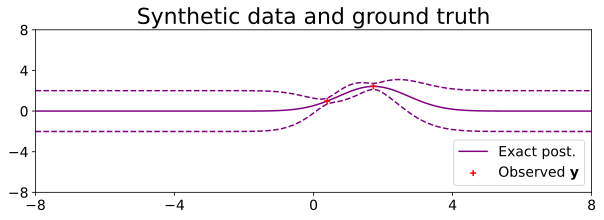

In [16]:
# Plot inducing points and observed data
plt.figure(figsize=(10, 3))
    
# Plot exact posterior predictive
plt.plot(x_plot, y_plot_mean - 2*y_plot_std, '--', color='purple',  zorder=2)
plt.plot(x_plot, y_plot_mean, color='purple',  zorder=2, label='Exact post.')
plt.plot(x_plot, y_plot_mean + 2*y_plot_std, '--', color='purple',  zorder=2)

# Plot sampled data
plt.scatter(x_train,
            y_train,
            color='red',
            marker='+',
            zorder=3,
            label=r'Observed $\mathbf{y}$')

# Plot formatting
plt.title('Synthetic data and ground truth', fontsize=22)
plt.xticks(np.arange(-8, 9, 4), fontsize=14)
plt.yticks(np.arange(-8, 9, 4), fontsize=14)
plt.legend(loc='lower right', fontsize=14)
plt.xlim([-8., 8.])
plt.show()

### Implementing the VFE GP

We can now put things together and implement the `VFEGP`. The `post_pred` and `free_energy` methods usee the Woodbury identity to speed up the inversion of the matrices required in this computation. It turns out however that when using the Woodbury identity, some of the matrices involved are poorly condtitioned. To alleviate this issue, I've found it necessary to make use of a [conditioning trick](https://gpflow.readthedocs.io/en/master/notebooks/theory/SGPR_notes.html?highlight=variational) also used in the GPFlow library.

In [17]:
class VFEGP(tf.keras.Model):
    
    def __init__(self,
                 x_train,
                 y_train,
                 x_ind_init,
                 mean,
                 cov,
                 log_noise,
                 dtype,
                 name='vfe_gp',
                 **kwargs):
        
        super().__init__(name=name, dtype=dtype, **kwargs)
        
        # Set training data and inducing point initialisation
        self.x_train = tf.convert_to_tensor(x_train, dtype=dtype)
        self.y_train = tf.convert_to_tensor(y_train, dtype=dtype)
        
        # Set inducing points
        self.x_ind = tf.convert_to_tensor(x_ind_init, dtype=dtype)
        self.x_ind = tf.Variable(self.x_ind)
        
        # Set mean and covariance functions
        self.mean = mean
        self.cov = cov
    
        # Set log of noise parameter
        self.log_noise = tf.convert_to_tensor(log_noise,
                                              dtype=dtype)
        self.log_noise = tf.Variable(self.log_noise)
        
        
    def post_pred(self, x_pred):
        
        # Compute covariance terms
        K_ind_ind = self.cov(self.x_ind, self.x_ind, epsilon=1e-4)
        K_train_ind = self.cov(self.x_train, self.x_ind)
        K_ind_train = self.cov(self.x_ind, self.x_train)
        K_pred_ind = self.cov(x_pred, self.x_ind)
        K_ind_pred = self.cov(self.x_ind, x_pred)
        K_pred_pred_diag = self.cov(x_pred, x_pred, diag=True)
        
        # Compute cholesky factor for numerical stability
        U = K_ind_ind + tf.matmul(K_ind_train, K_train_ind) / self.noise
        U_chol = tf.linalg.cholesky(U)
        
        # Difference between training data and mean
        diff = self.y_train - self.mean(self.x_train)[:, None]
        beta = tf.linalg.cholesky_solve(U_chol, tf.matmul(K_ind_train, diff))
        beta = beta / self.noise
        
        # Mean at plotting locations
        mean = tf.matmul(K_pred_ind, beta)[:, 0] + self.mean(x_pred)
        
        L = tf.linalg.cholesky(K_ind_ind)
        M = tf.linalg.triangular_solve(L, K_ind_pred, lower=True)
        
        var = K_pred_pred_diag
        var = var - tf.linalg.diag_part(tf.matmul(M, M, transpose_a=True))
        var = var + self.noise ** 2
        
        return mean, var
        
        
    def free_energy(self):
        
        # Number of training points
        N = self.y_train.shape[0]
        M = self.x_ind.shape[0]
        
        # Compute covariance terms
        K_ind_ind = self.cov(self.x_ind, self.x_ind, epsilon=1e-6)
        K_train_ind = self.cov(self.x_train, self.x_ind)
        K_ind_train = self.cov(self.x_ind, self.x_train)
        K_train_train = self.cov(self.x_train, self.x_train)
        
        # Compute shared matrix and its cholesky:
        # LLT = K_ind_ind
        # U = I + L-1 K_train_ind K_ind_train L / noise ** 2
        L = tf.linalg.cholesky(K_ind_ind)
        U = tf.linalg.triangular_solve(L, K_ind_train, lower=True)
        A = U / self.noise
        B = tf.eye(M, dtype=self.dtype) + tf.matmul(A, A, transpose_b=True)
        B_chol = tf.linalg.cholesky(B)
        
        # Compute log-normalising constant of the matrix
        log_pi = - N / 2 * tf.math.log(tf.constant(2 * np.pi, dtype=self.dtype))
        log_det_B = - tf.reduce_sum(tf.math.log(tf.linalg.diag_part(B)))
        log_det_noise = - N / 2 * tf.math.log(self.noise ** 2)
        
        # Log of determinant of normalising term
        log_det = log_pi + log_det_B + log_det_noise       
        
        # Compute quadratic form
        diff = self.y_train - self.mean(self.x_train)[:, None]
        c = tf.linalg.triangular_solve(B_chol, tf.matmul(A, diff), lower=True) / self.noise
        quad = - 0.5 * tf.reduce_sum((diff / self.noise) ** 2)
        quad = quad + 0.5 * tf.reduce_sum(c ** 2)
        
        # Compute trace term
        trace = - 0.5 * tf.linalg.trace(K_train_train) / self.noise ** 2
        trace = trace + 0.5 * tf.linalg.trace(tf.matmul(A, A, transpose_b=True))
        
        free_energy = (log_det + quad + trace) / N
        
        return free_energy
    
    
    @property
    def noise(self):
        return tf.math.exp(self.log_noise)

In [18]:
def plot(model,
         ground_truth_cov,
         x_pred,
         x_train,
         y_train,
         x_ind_init,
         step):

    # Get exact and approximate posterior predictive
    vfe_mean, vfe_var = model.post_pred(x_pred)

    # Covariances between inducing points and input locations
    K_train_plot = ground_truth_cov(x_train, x_plot)
    K_plot_train = ground_truth_cov(x_plot, x_train)
    K_plot_diag = ground_truth_cov(x_plot, x_plot, diag=True)

    # Mean and standard deviation of y_plot | f_ind, x_plot
    exact_mean = np.dot(K_plot_train, np.linalg.solve(K_train_train + I_noise, y_train))[:, 0]
    exact_var = K_plot_diag - np.diag(np.dot(K_plot_train,
                                       np.linalg.solve(K_train_train + I_noise, K_train_plot)))
    exact_std = (exact_var + noise) ** 0.5
    
    x_pred = x_pred[:, 0].numpy()
    x_ind = model.x_ind[:, 0].numpy()
    
    vfe_mean = vfe_mean.numpy()
    vfe_var = vfe_var.numpy()
    
    plt.figure(figsize=(8, 3))
    
    # Plot posterior predictive
    plt.plot(x_pred,
             vfe_mean,
             color='black',
             zorder=1,
             label='Approx. Post.')
    
    plt.fill_between(x_pred,
                     vfe_mean - 2 * vfe_var ** 0.5,
                     vfe_mean + 2 * vfe_var ** 0.5,
                     color='gray',
                     alpha=0.3)
    
    # Plot exact posterior
    plt.plot(x_plot,
             exact_mean - 2*exact_std,
             '--',
             color='purple',
             zorder=1)
    
    plt.plot(x_plot,
             exact_mean,
             color='purple',
             zorder=1)
    
    plt.plot(x_plot,
             exact_mean + 2*exact_std,
             '--',
             color='purple',
             zorder=1,
             label='Exact Post.')

    # Plot training data
    plt.scatter(x_train, y_train, color='red', marker='+', zorder=2)
    
    # Plot initial inducing points
    plt.scatter(x_ind_init,
                -5.5 * tf.ones_like(x_ind_init),
                color='green',
                marker='+',
                label=r'Init. $\bar{\mathbf{X}}$',
                zorder=2)
    
    # Plot current inducing points
    plt.scatter(x_ind,
                -5. * tf.ones_like(x_ind),
                color='blue',
                marker='+',
                label=r'Curr. $\bar{\mathbf{X}}$',
                zorder=2)
    
    # Format plot
    plt.title(f'VFE after {step} optimisation steps', fontsize=18)
    
    plt.xticks(np.arange(-10, 11, 4), fontsize=14)
    plt.yticks(np.arange(-6, 7, 3), fontsize=14)
    
    plt.xlim([-8., 8.])
    plt.ylim([-8., 4.])
    
    plt.legend(loc='lower right', fontsize=10)
    
    plt.show()
    
    
def print_info(model, step):
    
    free_energy = model.free_energy()
    print(f'Step: {step:5>} '
          f'Free energy: {free_energy.numpy():8.3f} '
          f'Coeff: {model.cov.coeff.numpy():5.2f} '
          f'Scales: {[round(num, 3) for num in model.cov.scales.numpy()]} '
          f'Noise: {model.noise.numpy():5.2f}')

Step: 0 Free energy:  -16.486 Coeff:  1.00 Scales: [1.0] Noise:  0.37


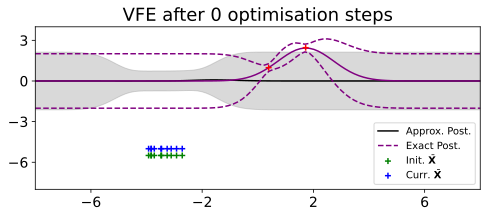

Step: 1000 Free energy:   -1.115 Coeff:  0.02 Scales: [5.25] Noise:  0.74


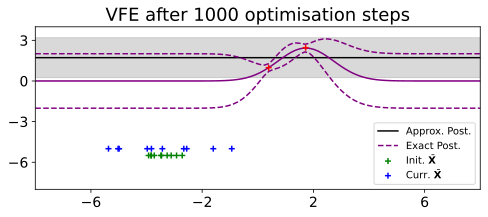

In [19]:
# Set random seed and tensor dtype
tf.random.set_seed(1)
dtype = tf.float64

# Number GP constants
M = 10
inducing_range = (-4., -2.)
log_noise = -1.
log_coeff = 0.
log_scales = [0.]

# Define mean and covariance
mean = ConstantMean(dtype=dtype)

cov = EQcovariance(log_coeff=log_coeff,
                   log_scales=log_scales,
                   dim=1,
                   dtype=dtype)

# Initial locations of inducing points
x_ind_dist = tfp.distributions.Uniform(low=inducing_range[0], high=inducing_range[1])
x_ind_init = x_ind_dist.sample(sample_shape=(M, 1))
x_ind_init = tf.cast(x_ind_init, dtype=dtype)

# Define sparse VFEGP
vfe_gp = VFEGP(mean=mean,
               cov=cov,
               log_noise=log_noise,
               x_train=x_train,
               y_train=y_train,
               x_ind_init=x_ind_init,
               dtype=dtype)

num_steps = 1000
optimizer = tf.keras.optimizers.Adam(1e-1)

x_pred = tf.linspace(-8., 8., 100)[:, None]
x_pred = tf.cast(x_pred, dtype=tf.float64)

for step in range(num_steps + 1):
    
    with tf.GradientTape() as tape:

        free_energy = vfe_gp.free_energy()
        loss = - free_energy
        
        # Print information and plot at start and end
        if step % num_steps == 0:
            
            print_info(vfe_gp, step)

            plot(vfe_gp,
                 ground_truth_cov,
                 x_pred,
                 x_train,
                 y_train,
                 x_ind_init,
                 step)

    gradients = tape.gradient(loss, vfe_gp.trainable_variables)
    optimizer.apply_gradients(zip(gradients, vfe_gp.trainable_variables))

Initially the positions of the inducing points (green) do not allow for an expressive enough posterior to match the exact GP posterior. By spreading out the inducing points, the model manages to recover an approximate posterior that is very close to the ground truth. We were expecting this to be possible since there are lots of observed data which are redundant, and should be summarisable by a smaller set of inducing points.

## Conclusion

We have seen how the free energy may be used together with an inducing point approximate posterior to reduce the computational cost of doing infernce and learning with GPs. Unlike other methods such as DTC and FITC, the VFE method approximates the posterior rather than the model, bringing several benefits. VFE decouples model assumptions and approximations. In this way, it keeps the exact model sacrosanct and attempts to approximate it as faithfully as possible. Second, because the Free Energy is a lower bound to the marginal log-likelihood, it is impossible for VFE to overfit any more than the exact. model. By contrast, other methods can overfit more than the original GP.  VFE explicitly represents posterior uncertainty, keeping it separate from noise uncertainty whereas methods do not.

## References

```{bibliography} ./vfe.bib
```